# Generative Adversarial Network

* https://github.com/znxlwm/pytorch-generative-model-collections
* Generative Adversarial Networks https://arxiv.org/abs/1406.2661
* Generative Adversarial Networks: An Overview
* Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks https://arxiv.org/abs/1511.06434

In [1]:
!pip install torch torchvision
!pip install Pillow==4.1.1

Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple
Looking in indexes: https://pypi.org/simple, https://legacy.pypi.org/simple


In [0]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## MNIST

* Generatorは62次元のランダムベクトルzを入力として1チャンネルの28x28の画像を出力
* ConvTranspose2d
* 入力は4Dテンソル (N, C1, H1, W1) 出力は4Dテンソル (N, C2, H2, W2)
* H2 = (H1-1)stride - 2padding + kernel_size
* W2 = (W1-1)stride - 2padding + kernel_size
* 1つめのConvTranspose2d $(7-1)*2 - 2*1 + 4 = 14$
* 2つめのConvTranspose2d $(14-1)*2 - 2*1 + 4 = 28$

In [0]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

In [6]:
# Generatorのサイズテスト
G = Generator()
input = torch.rand((32, 62))
out = G(input)
print(out.size())

torch.Size([32, 1, 28, 28])


In [7]:
G

Generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

* 28x28の画像を入力して本物か偽物かを表す0-1の数値を出力する
* MaxPooling2dを使わずにstrideで画像サイズを半分にする

In [0]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc(x)
        return x

In [10]:
# Discriminatorのサイズテスト
D = Discriminator()
input = torch.rand((32, 1, 28, 28))
out = D(input)
print(out.size())

torch.Size([32, 1])


In [11]:
D

Discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

### 学習ポイント

* Pooling層をstrided convolution（for D）、fractional-strided convolutions (for G)に置き換える
* G、DともにBatchNormを使う
* 層が深いときはFC層を除去する
* GにはReLUを使う、ただし出力層のみTanh、今回は0-1標準化の画像なのでSigmoid使用（適用済み）
* DにはLeakyReLUを使う
* GeneratorとDiscriminatorはそれぞれoptimizerがある
* 参考先では loss.cuda() しているがlossはパラメータがないのでしなくてOK
* https://discuss.pytorch.org/t/what-exactly-does-loss-cuda-do/7450

In [0]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [0]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [0]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [0]:
def train(D, G, criterion, D_optimizer, G_optimizer, data_loader):
    # 訓練モードへ
    D.train()
    G.train()

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    for batch_idx, (real_images, _) in enumerate(data_loader):
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real = D(real_images)
        D_real_loss = criterion(D_real, y_real)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake = D(fake_images.detach())
        D_fake_loss = criterion(D_fake, y_fake)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        # GeneratorにとってGeneratorが生成した画像の認識結果は1（本物）に近いほどよい
        # E[log(D(G(z)))
        fake_images = G(z)
        D_fake = D(fake_images)
        G_loss = criterion(D_fake, y_real)
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss

### detach()の必要性

* https://github.com/pytorch/examples/issues/116
* D_optimizerにはDのパラメータしか渡しておらず、D_optimizer.step()してもGeneratorのパラメータは更新されないためdetach()しなくても結果はかわらない
* ただ、明示的にdetach()することでfake_imagesを通じてGeneratorに勾配が伝搬することを防ぎ、計算が高速化される

### GANのloss function

* Discriminatorのvalue function（大きい方がよいのでlossではない）
* $L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z)))] \to max$
* D(x)はDiscriminatorで0〜1を返す、1に近いほど入力が本物画像と判定
* G(z)はGeneratorが乱数zから生成した偽物画像を表す
* 本物画像xを入力したときはD(x)が1に近いほどよい（本物と正しく判定）
* 偽物画像G(z)を入力したときはD(G(z))が0に近いほどよい（偽物と正しく判定）
* Generatorのvalue function
* $L_G^{GAN} = E[log(D(G(z)))] \to max$
* 偽物画像G(z)を入力したときにD(G(z))が1に近いほどよい（偽物を本物と騙せた）

In [0]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    # 生成のもとになる乱数を生成
    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    # Generatorでサンプル生成
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [18]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

# 学習履歴を保存
with open(os.path.join(log_dir, 'history.pkl'), 'wb') as f:
    pickle.dump(history, f)

epoch 1, D_loss: 0.7617 G_loss: 1.3569
epoch 2, D_loss: 0.8796 G_loss: 1.2889
epoch 3, D_loss: 0.9393 G_loss: 1.1994
epoch 4, D_loss: 0.9286 G_loss: 1.2218
epoch 5, D_loss: 0.9332 G_loss: 1.2408
epoch 6, D_loss: 0.9222 G_loss: 1.2648
epoch 7, D_loss: 0.8971 G_loss: 1.2966
epoch 8, D_loss: 0.8838 G_loss: 1.3397
epoch 9, D_loss: 0.8676 G_loss: 1.3649
epoch 10, D_loss: 0.8409 G_loss: 1.4058
epoch 11, D_loss: 0.8295 G_loss: 1.4484
epoch 12, D_loss: 0.8073 G_loss: 1.4927
epoch 13, D_loss: 0.7872 G_loss: 1.5205
epoch 14, D_loss: 0.7655 G_loss: 1.5862
epoch 15, D_loss: 0.7642 G_loss: 1.6092
epoch 16, D_loss: 0.7224 G_loss: 1.6533
epoch 17, D_loss: 0.7183 G_loss: 1.6903
epoch 18, D_loss: 0.6996 G_loss: 1.7247
epoch 19, D_loss: 0.6794 G_loss: 1.7714
epoch 20, D_loss: 0.6687 G_loss: 1.8338
epoch 21, D_loss: 0.6458 G_loss: 1.8788
epoch 22, D_loss: 0.6404 G_loss: 1.9109
epoch 23, D_loss: 0.6392 G_loss: 1.9204
epoch 24, D_loss: 0.6162 G_loss: 1.9497
epoch 25, D_loss: 0.5778 G_loss: 2.0096


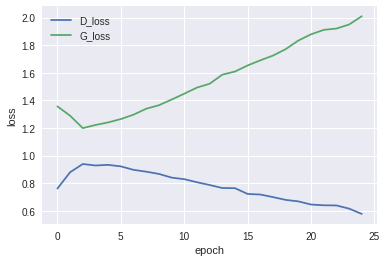

In [19]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

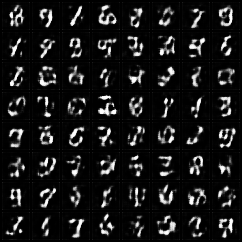

In [20]:
from IPython.display import Image
Image('logs/epoch_001.png')

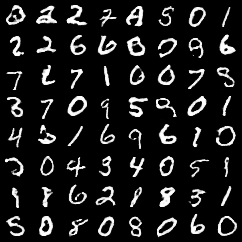

In [21]:
Image('logs/epoch_010.png')

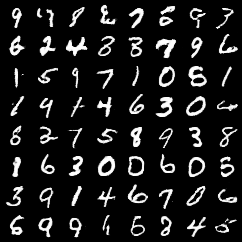

In [22]:
Image('logs/epoch_025.png')

## Fashion MNIST

In [0]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.FashionMNIST('data/fashion-mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)  

(-0.5, 145.5, 145.5, -0.5)

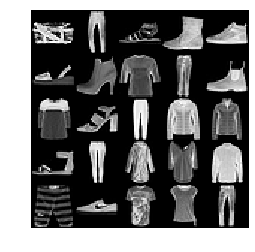

In [24]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [0]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [29]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

epoch 1, D_loss: 0.8257 G_loss: 1.2327
epoch 2, D_loss: 0.9174 G_loss: 1.2433
epoch 3, D_loss: 0.9936 G_loss: 1.1545
epoch 4, D_loss: 1.0025 G_loss: 1.1402
epoch 5, D_loss: 0.9962 G_loss: 1.1573
epoch 6, D_loss: 0.9861 G_loss: 1.1716
epoch 7, D_loss: 0.9677 G_loss: 1.1969
epoch 8, D_loss: 0.9518 G_loss: 1.2284
epoch 9, D_loss: 0.9428 G_loss: 1.2460
epoch 10, D_loss: 0.9285 G_loss: 1.2708
epoch 11, D_loss: 0.9215 G_loss: 1.2896
epoch 12, D_loss: 0.9007 G_loss: 1.3114
epoch 13, D_loss: 0.8890 G_loss: 1.3386
epoch 14, D_loss: 0.8658 G_loss: 1.3740
epoch 15, D_loss: 0.8558 G_loss: 1.3996
epoch 16, D_loss: 0.8330 G_loss: 1.4365
epoch 17, D_loss: 0.8146 G_loss: 1.4935
epoch 18, D_loss: 0.7961 G_loss: 1.5090
epoch 19, D_loss: 0.7923 G_loss: 1.5382
epoch 20, D_loss: 0.7663 G_loss: 1.5770
epoch 21, D_loss: 0.7490 G_loss: 1.6132
epoch 22, D_loss: 0.7406 G_loss: 1.6360
epoch 23, D_loss: 0.7267 G_loss: 1.6828
epoch 24, D_loss: 0.7150 G_loss: 1.6982
epoch 25, D_loss: 0.6988 G_loss: 1.7363


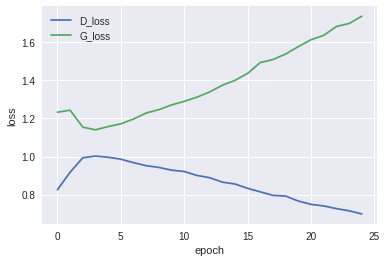

In [30]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

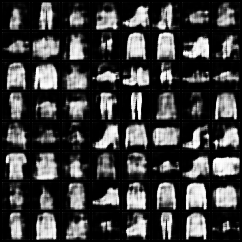

In [31]:
Image('logs/epoch_001.png')

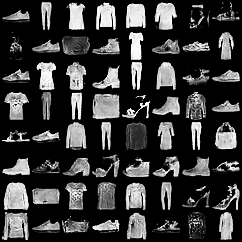

In [32]:
Image('logs/epoch_010.png')

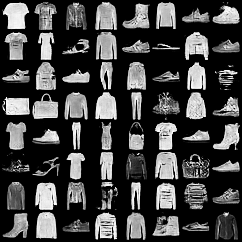

In [33]:
Image('logs/epoch_025.png')

## CelebA

* 事前に下のGoogle Driveを自分のGoogle Driveにコピーしておく
* http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
* ocamlfuseをインストールしてGoogle Driveをマウントする

In [34]:
# google-drive-ocamlfuseのインストール
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Colab用のAuth token作成
from google.colab import auth
auth.authenticate_user()

# Drive FUSE library用のcredential生成
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# drive/ を作り、そこにGoogle Driveをマウントする
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Google DriveのデータをColabのインスタンスにコピーしてくる
!cp drive/Colab\ Notebooks/data/CelebA/Img/img_align_celeba.zip .
!mkdir data/celebA
!unzip img_align_celeba.zip -d data/celebA
!ls data/celebA
!mkdir logs

In [0]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 25
sample_num = 16
log_dir = './logs'

In [0]:
# load dataset
transform = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
# celebAの下に直接画像ファイルがあってはダメ！
# クラスのディレクトリが入る必要がある（今回はimg_align_celebaでOK）
dataset = datasets.ImageFolder('data/celebA', transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)  

(-0.5, 325.5, 325.5, -0.5)

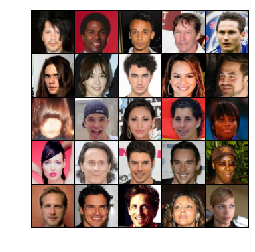

In [38]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [0]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 16 * 16),
            nn.BatchNorm1d(128 * 16 * 16),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 16 * 16, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc(x)
        return x

In [0]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# loss
criterion = nn.BCELoss()

In [0]:
history = {}
history['D_loss'] = []
history['G_loss'] = []
for epoch in range(num_epochs):
    D_loss, G_loss = train(D, G, criterion, D_optimizer, G_optimizer, data_loader)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # 特定のエポックでGeneratorから画像を生成してモデルも保存
    if epoch == 0 or epoch == 9 or epoch == 24:
        generate(epoch + 1, G, log_dir)
        torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
        torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

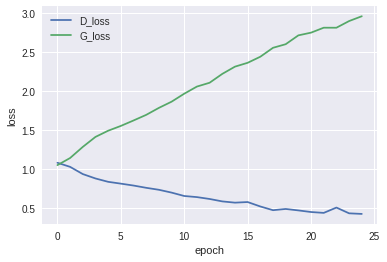

In [14]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

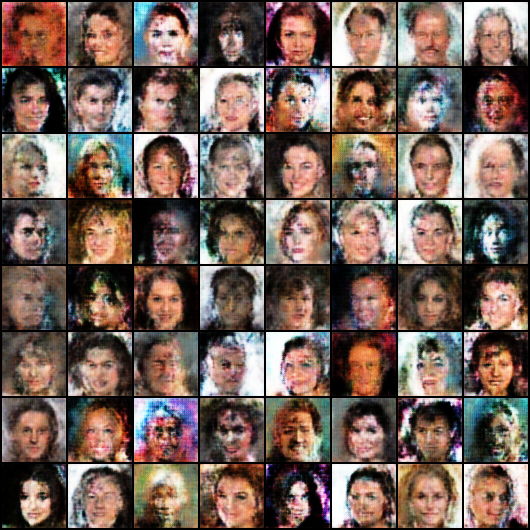

In [15]:
from IPython.display import Image
Image('logs/epoch_001.png')

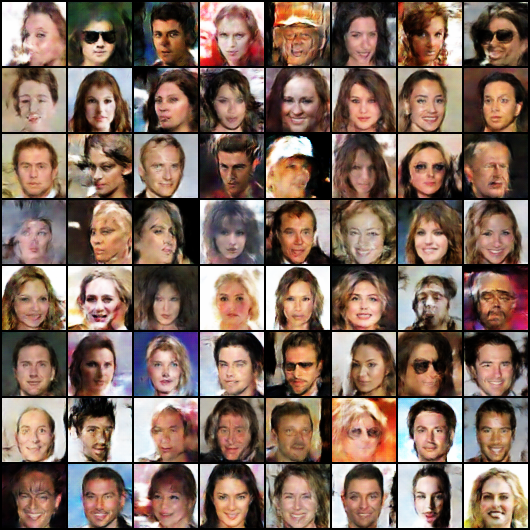

In [16]:
Image('logs/epoch_010.png')

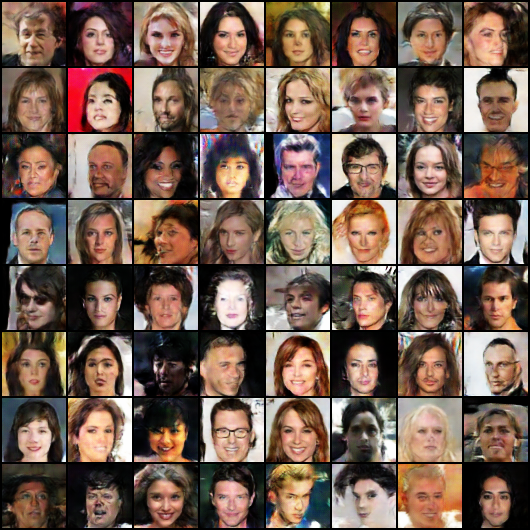

In [17]:
Image('logs/epoch_025.png')